In [122]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt
from sklearn.metrics import mean_squared_error

In [3]:
input_df = pd.read_csv("input_data_nn.csv", sep=";")
output_df = pd.read_csv("output_data_nn.csv", sep=";")

In [72]:
statues_cols = [
 'status_1_gerador_subrede_230kv',
 'status_2_gerador_subrede_230kv',
 'status_3_gerador_subrede_230kv',
 'status_4_gerador_subrede_230kv',
 'status_5_gerador_subrede_230kv',
 'status_6_gerador_subrede_230kv',
 'status_7_gerador_subrede_230kv',
 'status_8_gerador_subrede_230kv',
 'status_9_gerador_subrede_230kv',
 'status_10_gerador_subrede_230kv',
 'status_11_gerador_subrede_230kv',
 'status_12_gerador_subrede_230kv',
 'status_13_gerador_subrede_230kv',
 'status_14_gerador_subrede_230kv',
 'status_15_gerador_subrede_230kv',
 'status_16_gerador_subrede_230kv',
 'status_17_gerador_subrede_230kv',
 'status_18_gerador_subrede_230kv',
 'status_1_linha_subrede_230kv',
 'status_2_linha_subrede_230kv',
 'status_3_linha_subrede_230kv',
 'status_4_linha_subrede_230kv',
 'status_5_linha_subrede_230kv',
 'status_6_linha_subrede_230kv',
 'status_7_linha_subrede_230kv',
 'status_8_linha_subrede_230kv',
 'status_9_linha_subrede_230kv',
 'status_10_linha_subrede_230kv',
 'status_11_linha_subrede_230kv',
 'status_12_linha_subrede_230kv',
 'status_13_linha_subrede_230kv',
 'status_14_linha_subrede_230kv',
 'status_15_linha_subrede_230kv',
 'status_16_linha_subrede_230kv',
 'status_17_linha_subrede_230kv',
 'status_18_linha_subrede_230kv',
 'status_19_linha_subrede_230kv',
 'status_20_linha_subrede_230kv',
 'status_21_linha_subrede_230kv'  
]

In [4]:
df = pd.concat([input_df, output_df], axis=1)

In [5]:
cols = output_df.columns.tolist() + input_df.columns.tolist()

In [6]:
df = df[cols]

In [8]:
test_split=round(len(df)*0.30)
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(6132, 51)
(2628, 51)


In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[8.85093517e-01, 9.06639273e-01, 9.32329304e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.79535979e-01, 6.06571508e-01, 4.59123825e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.93556780e-01, 6.15978314e-01, 4.73560006e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.90426301e-01, 6.10941843e-01, 4.25390855e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.04570513e-06, 1.28604370e-03, 8.91710797e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.02700704e-06, 4.03680547e-03, 9.20884716e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [128]:
days = 1
max_idx_pred = 3

In [129]:
def createXY(dataset, max_idx_pred, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i, 0:max_idx_pred])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled, max_idx_pred, 24 * days)
testX,testY=createXY(df_for_testing_scaled, max_idx_pred, 24 * days)

print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

trainX Shape--  (6108, 24, 51)
trainY Shape--  (6108, 3)
testX Shape--  (2604, 24, 51)
testY Shape--  (2604, 3)


In [131]:
def build_model():
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(24 * days, trainX.shape[-1])))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(max_idx_pred))

    grid_model.compile(loss = 'mse',optimizer = 'adam')
    grid_model.fit(trainX,trainY, batch_size =  16, epochs = 10, validation_data = (testX, testY))
    
    return grid_model

model = build_model()

Epoch 1/10
382/382 [==============================] - 10s 20ms/step - loss: 0.0701 - val_loss: 0.0386
Epoch 2/10
382/382 [==============================] - 6s 15ms/step - loss: 0.0385 - val_loss: 0.0327
Epoch 3/10
382/382 [==============================] - 7s 17ms/step - loss: 0.0367 - val_loss: 0.0322
Epoch 4/10
382/382 [==============================] - 6s 15ms/step - loss: 0.0361 - val_loss: 0.0321
Epoch 5/10
382/382 [==============================] - 6s 15ms/step - loss: 0.0343 - val_loss: 0.0317
Epoch 6/10
382/382 [==============================] - 6s 15ms/step - loss: 0.0339 - val_loss: 0.0310
Epoch 7/10
382/382 [==============================] - 6s 15ms/step - loss: 0.0336 - val_loss: 0.0310
Epoch 8/10
382/382 [==============================] - 7s 17ms/step - loss: 0.0328 - val_loss: 0.0307
Epoch 9/10
382/382 [==============================] - 8s 21ms/step - loss: 0.0323 - val_loss: 0.0299
Epoch 10/10
382/382 [==============================] - 7s 17ms/step - loss: 0.0319 - val_l

In [132]:
prediction=model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[ 0.8194531   0.8163133   0.691195  ]
 [ 0.5691632   0.5689094   0.3549682 ]
 [ 0.604077    0.60768217  0.41525698]
 ...
 [ 0.75693536  0.7547143   0.7459569 ]
 [ 0.42925036  0.4427657   0.4184869 ]
 [ 0.00318915 -0.00400533  0.01306745]]

Prediction Shape- (2604, 3)


In [133]:
def inverse_transform(arrs):
    zeros_padding = np.zeros(testX.shape[-1] - (max_idx_pred))
    arrs_copies = list(map(lambda arr: np.concatenate((arr, zeros_padding)), arrs))
    return scaler.inverse_transform(np.reshape(arrs_copies, (len(arrs), testX.shape[-1])))
#[:,1]

In [134]:
pred = inverse_transform(prediction)
originals = inverse_transform(testY)

In [145]:
print("pred tensao_barramento11: " + str(pred[:,0]))
print("original tensao_barramento11: " + str(originals[:,0]))
print()
print("pred tensao_barramento12: " + str(pred[:,1]))
print("original tensao_barramento12: " + str(originals[:,1]))
print()
print("pred tensao_barramento24: " + str(pred[:,2]))
print("original tensao_barramento24: " + str(originals[:,2]))
print()
print("pred tensao_barramento24: " + str(pred[:,2]))
print("original tensao_barramento24: " + str(originals[:,2]))
print()

pred tensao_barramento11: [1.01408387 0.99451039 0.99724076 ... 1.00919478 0.98356876 0.9502494 ]
original tensao_barramento11: [1.00269358 1.00453829 1.00513947 ... 1.0019635  0.95127084 0.95126964]

pred tensao_barramento12: [1.01298961 0.99389906 0.9968909  ... 1.00823642 0.98416536 0.94969093]
original tensao_barramento12: [0.99990073 1.00272539 1.00364593 ... 1.00335917 0.95157989 0.95158083]

pred tensao_barramento24: [0.99917051 0.97525187 0.97954072 ... 1.00306618 0.97977049 0.9509296 ]
original tensao_barramento24: [0.98334365 0.98592246 0.98566991 ... 1.00685737 0.95000062 0.95000064]



In [135]:
def rmse(index):
    plt.plot(originals[:,index], color = 'red', label = 'Real Stock Price')
    plt.plot(pred[:,index], color = 'blue', label = 'Predicted Stock Price')
    plt.legend()
    plt.show()
    return sqrt(mean_squared_error(originals[:,index], pred[:,index]))

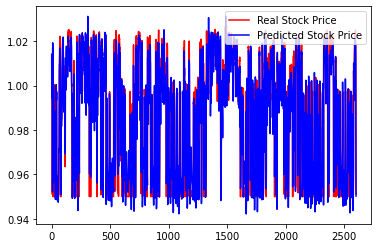

0.013209944453516954

In [136]:
rmse(0)

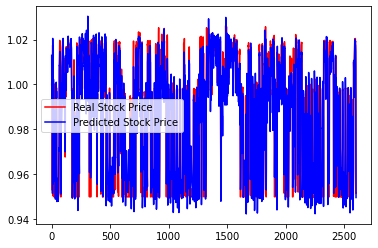

0.013371335262210036

In [137]:
rmse(1)

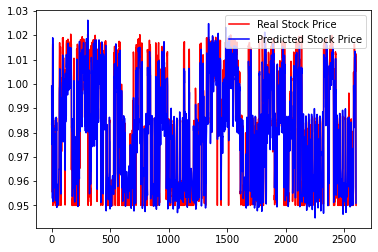

0.012509234154587136

In [138]:
rmse(2)

## Grid search

In [163]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,51)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    # {'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}
    grid_model.fit(trainX,trainY, batch_size =  16, epochs = 10,validation_data=(testX, testY))
    
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))

parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)


grid_search = grid_search.fit(trainX,trainY)
grid_search.best_params_
my_model=grid_search.best_estimator_.model

/tmp/ipykernel_10384/1044546172.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))


In [305]:
prediction_copies_array = np.repeat(prediction, 25, axis=1)
prediction_copies_array_m = list(map(lambda pred: (pred.tolist() * 25) + [pred.tolist()[0]], prediction))
pred = scaler.inverse_transform(np.reshape(prediction_copies_array_m,(len(prediction),51)))[:,1]